In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 9912422/9912422 [00:00<00:00, 78971312.95it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65834616.21it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23158574.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12828638.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_1x1, out_channels_3x3_reduce, out_channels_3x3, out_channels_5x5_reduce, out_channels_5x5, out_channels_pool):
        super(InceptionBlock, self).__init__()
        # 1x1 Convolution
        self.conv1x1 = nn.Conv2d(in_channels, out_channels_1x1, kernel_size=1)
        # 1x1 Convolution followed by 3x3 Convolution
        self.conv3x3_reduce = nn.Conv2d(in_channels, out_channels_3x3_reduce, kernel_size=1)
        self.conv3x3 = nn.Conv2d(out_channels_3x3_reduce, out_channels_3x3, kernel_size=3, padding=1)
        # 1x1 Convolution followed by 5x5 Convolution
        self.conv5x5_reduce = nn.Conv2d(in_channels, out_channels_5x5_reduce, kernel_size=1)
        self.conv5x5 = nn.Conv2d(out_channels_5x5_reduce, out_channels_5x5, kernel_size=5, padding=2)
        # 3x3 Max Pooling followed by 1x1 Convolution
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv2d(in_channels, out_channels_pool, kernel_size=1)

    def forward(self, x):
        conv1x1 = self.conv1x1(x)
        conv3x3 = self.conv3x3(self.conv3x3_reduce(x))
        conv5x5 = self.conv5x5(self.conv5x5_reduce(x))
        pool = self.conv_pool(self.maxpool(x))
        return torch.cat([conv1x1, conv3x3, conv5x5, pool], 1)

class InceptionNet(nn.Module):
    def __init__(self):
        super(InceptionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.maxpool1(torch.relu(self.conv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = InceptionNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [8]:
num_epochs = 10
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100.0 * correct_train / total_train
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    net.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(testloader)
    test_accuracy = 100.0 * correct_test / total_test
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/10], Train Loss: 2.3016, Train Accuracy: 11.15%, Test Loss: 2.3012, Test Accuracy: 11.35%
Epoch [2/10], Train Loss: 2.3016, Train Accuracy: 11.15%, Test Loss: 2.3011, Test Accuracy: 11.35%
Epoch [3/10], Train Loss: 2.3016, Train Accuracy: 11.24%, Test Loss: 2.3014, Test Accuracy: 11.35%
Epoch [4/10], Train Loss: 2.3016, Train Accuracy: 11.19%, Test Loss: 2.3011, Test Accuracy: 11.35%
Epoch [5/10], Train Loss: 2.3016, Train Accuracy: 11.18%, Test Loss: 2.3012, Test Accuracy: 11.35%
Epoch [6/10], Train Loss: 2.3014, Train Accuracy: 11.24%, Test Loss: 2.3012, Test Accuracy: 11.35%
Epoch [7/10], Train Loss: 2.3013, Train Accuracy: 11.16%, Test Loss: 2.3013, Test Accuracy: 11.35%
Epoch [8/10], Train Loss: 2.3015, Train Accuracy: 11.24%, Test Loss: 2.3011, Test Accuracy: 11.35%
Epoch [9/10], Train Loss: 2.3015, Train Accuracy: 11.24%, Test Loss: 2.3012, Test Accuracy: 11.35%
Epoch [10/10], Train Loss: 2.3013, Train Accuracy: 11.19%, Test Loss: 2.3010, Test Accuracy: 11.35%


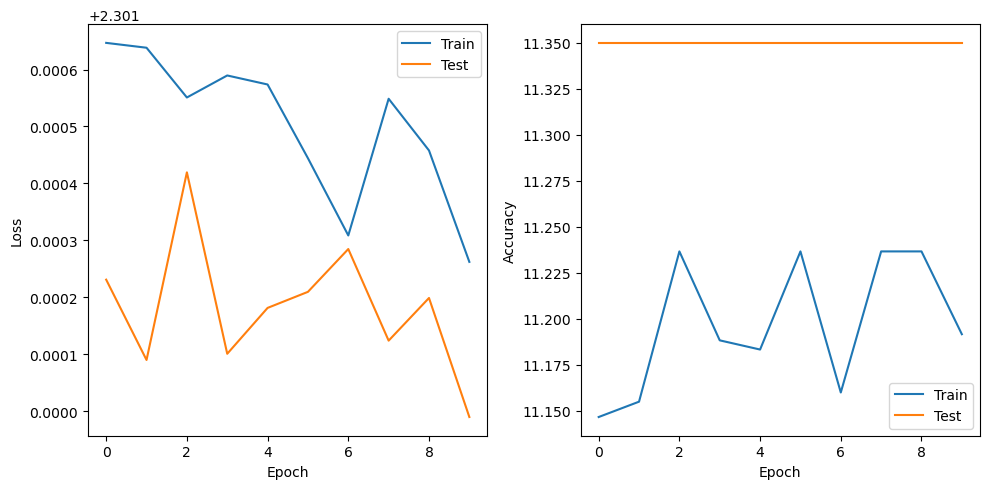

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train')
plt.plot(test_loss_list, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Train')
plt.plot(test_accuracy_list, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


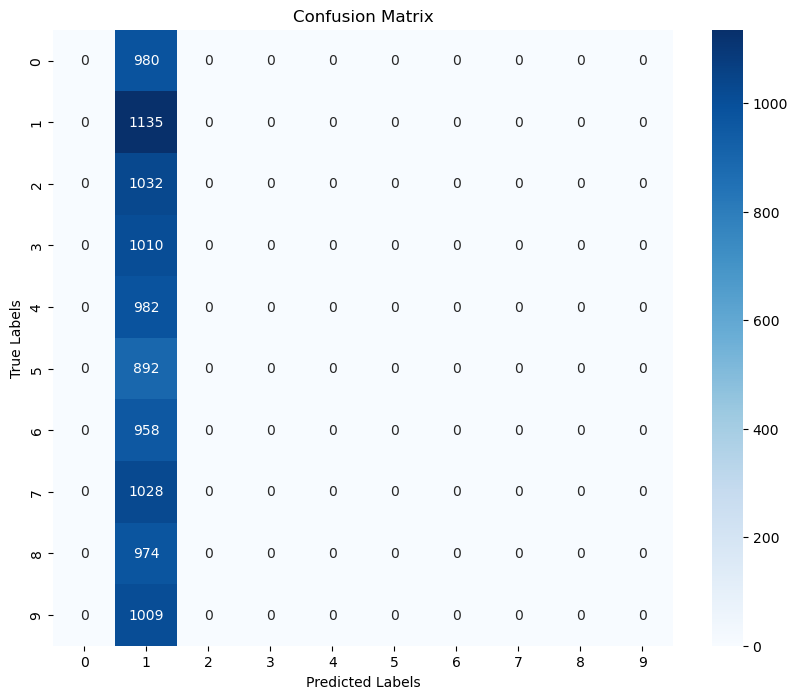

In [10]:
net.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions += predicted.tolist()
        all_labels += labels.tolist()

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
